# Автоматизация обнаружения злонамеренного трафика

Компания онлайн-сервис с высоким уровнем входящего трафика имеет специализированный отдел безопасности, который занимается фильтрацией и анализом трафика. Сотрудники этого отдела обратились за помощью в автоматизации выявления аномального и злонамеренного трафика.

**Цель проекта**

Основная цель это снижение убытков из-за хакерских атак. Нужно разработать модель, которая будет классифицировать трафик на нормальный и злонамеренный. При этом модель должна работать максимально качественно, так как неверная классификация может иметь серьезные последствия.

**План работ**

1. Проведём предобработку данных
2. Подготовим датасет для обучения моделей
3. Обучим 2 модели
4. Выберем, протестируем и проанализируем лучшую модель
5. Сделаем выводы
6. Разработаем REST API сервис, который будет принимать на вход данные трафика и возвращать класс этого трафика

**Описание данных**

Имеется датасет с информацией о входящем трафике с размеченной целевой переменной.

## Предобработка данных

### Импорт библиотек

In [1]:
%pip install lightgbm
%pip install missingno
%pip install shap
%pip install skimpy
%pip install joblib
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Импорт библиотек
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE

import lightgbm as lgb

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import warnings
np.warnings = warnings
warnings.filterwarnings('ignore')

import missingno as msno
import shap

from skimpy import skim, clean_columns
import joblib

# Фиксированный random_state
STATE = 42

### Загрузка датасета

In [3]:
df = pd.read_csv('network_traffic_data.csv')

In [4]:
# Включим отображение всех столбцов и строк
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

### Посмотрим основную информацию

In [5]:
df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,5480074,3,1,12,0,6,0,4.000,3.465,0,0,0.0,0.0,2.189751,0.729917,1.826691e+06,3.131700e+06,5442804,101,5480074,2740037.000,3.822290e+06,5442804,37270,0,0.000,0.00,0,0,0,0,0,0,72,32,0.547438,0.182479,0,6,2.4,3.287,10.8000,0,0,0,1,0,0,0,0,0,3.00,4.000,0.0,72,0,0,0,0,0,0,3,12,1,0,8192,42780,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,443,711977,9,10,703,3950,267,0,78.100,103.300,1448,0,395.0,587.5,6535.323473,26.686255,3.955428e+04,5.015462e+04,120501,1,616301,77037.625,7.299598e+04,215614,230,616874,68541.555,71985.97,199836,1,0,0,0,0,296,328,12.640858,14.045398,0,1448,232.6,442.800,196012.6600,0,0,0,1,0,0,0,0,1,244.90,78.100,395.0,296,0,0,0,0,0,0,9,703,10,3950,29200,252,4,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,53,153398,2,2,80,224,40,40,40.000,0.000,112,112,112.0,0.0,1981.772904,26.075959,5.113267e+04,8.855831e+04,153391,3,3,3.000,0.000000e+00,3,3,4,4.000,0.00,4,4,0,0,0,0,40,40,13.037980,13.037980,40,112,68.8,39.440,1555.2000,0,0,0,0,0,0,0,0,1,86.00,40.000,112.0,40,0,0,0,0,0,0,2,80,2,224,-1,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,53,57660,1,1,46,128,46,46,46.000,0.000,128,128,128.0,0.0,3017.689906,34.686091,5.766000e+04,0.000000e+00,57660,57660,0,0.000,0.000000e+00,0,0,0,0.000,0.00,0,0,0,0,0,0,20,20,17.343046,17.343046,46,128,73.3,47.340,2241.3333,0,0,0,0,0,0,0,0,1,110.00,46.000,128.0,20,0,0,0,0,0,0,1,46,1,128,-1,-1,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,8446,767,3,1,43,6,31,6,14.336,14.440,6,6,6.0,0.0,63885.267280,5215.123859,2.556667e+02,3.942896e+02,710,3,713,356.500,4.999245e+02,710,3,0,0.000,0.00,0,0,0,0,0,0,60,20,3911.342800,1303.781000,6,31,11.0,11.180,125.0000,0,0,0,0,1,0,0,0,0,13.75,14.336,6.0,60,0,0,0,0,0,0,3,43,1,6,1017,0,2,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539616 entries, 0 to 539615
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             539616 non-null  int64  
 1    Flow Duration                539616 non-null  int64  
 2    Total Fwd Packets            539616 non-null  int64  
 3    Total Backward Packets       539616 non-null  int64  
 4   Total Length of Fwd Packets   539616 non-null  int64  
 5    Total Length of Bwd Packets  539616 non-null  int64  
 6    Fwd Packet Length Max        539616 non-null  int64  
 7    Fwd Packet Length Min        539616 non-null  int64  
 8    Fwd Packet Length Mean       539616 non-null  float64
 9    Fwd Packet Length Std        539616 non-null  float64
 10  Bwd Packet Length Max         539616 non-null  int64  
 11   Bwd Packet Length Min        539616 non-null  int64  
 12   Bwd Packet Length Mean       539616 non-nul

- Имеем датасет в котором 539616 строчек и 79 столбцов
- Целевая переменная `Label`
- Имена признаков имеют пробелы

Приведём названия столбцов к змеиному регистру.

In [7]:
df = clean_columns(df)
df.columns

79 column names have been cleaned

Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes_s', 'flow_packets_s',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags',
       'fwd_urg_flags', 'bwd_urg_flags', 'fwd_header_length',
       'bwd_header_length', 'fwd_packets_s', 'bwd_packets_s',
       'min_packet_length', 'max_packet_length', 'packet_length_mean',
       'packet_length_std', 'packet_length_variance', 'fin_flag_count',
       'syn_flag_co

Посмотрим описание данных

In [8]:
df.describe().T.style.set_caption('Таблица числового описания датасета')

,count,mean,std,min,25%,50%,75%,max
destination_port,539616.000000,5563.061394,14921.262751,0.000000,80.000000,80.000000,443.000000,65533.000000
flow_duration,539616.000000,21066929.368501,38121719.627258,-12.000000,73.000000,49739.000000,10640295.250000,119999993.000000
total_fwd_packets,539616.000000,6.119972,345.109317,1.000000,1.000000,2.000000,6.000000,200755.000000
total_backward_packets,539616.000000,5.985495,463.490949,0.000000,1.000000,2.000000,5.000000,270686.000000
total_length_of_fwd_packets,539616.000000,408.237107,7478.350579,0.000000,2.000000,44.000000,320.000000,2866110.000000
total_length_of_bwd_packets,539616.000000,7999.779419,1014441.804219,0.000000,0.000000,105.000000,8216.250000,591000000.000000
fwd_packet_length_max,539616.000000,169.449966,560.533869,0.000000,2.000000,23.000000,272.000000,24820.000000
fwd_packet_length_min,539616.000000,11.855382,60.961661,0.000000,0.000000,0.000000,6.000000,2065.000000
fwd_packet_length_mean,539616.000000,44.681011,150.873880,0.000000,2.000000,11.220000,48.560000,5940.000000
fwd_packet_length_std,539616.000000,59.525095,217.729412,0.000000,0.000000,0.000000,91.700000,7050.000000


- Можно заметить, что в столбцах `flow_bytes_s` и `flow_packets_s` присутствуют бесконечные значения. Удалим бесконечные значения.
- В столбцах `bwd_psh_flags` `bwd_urg_flags` `fwd_avg_bytes_bulk` `fwd_avg_packets_bulk` `fwd_avg_bulk_rate` `bwd_avg_bytes_bulk` `bwd_avg_packets_bulk` `bwd_avg_bulk_rate` все значений нулевые. Удалим эти столбцы.

Удалим бесконечные значения в столбцах `flow_bytes_s` `flow_packets_s`

In [9]:
df = df.replace(np.inf, np.nan).dropna()

Удалим столбцы с нулевыми значениями.

In [10]:
null_list = ['bwd_psh_flags', 'bwd_urg_flags', 'fwd_avg_bytes_bulk', 'fwd_avg_packets_bulk', 
             'fwd_avg_bulk_rate', 'bwd_avg_bytes_bulk', 'bwd_avg_packets_bulk', 'bwd_avg_bulk_rate']

df.drop(null_list, axis=1, inplace=True)

### Проверка на пропуски

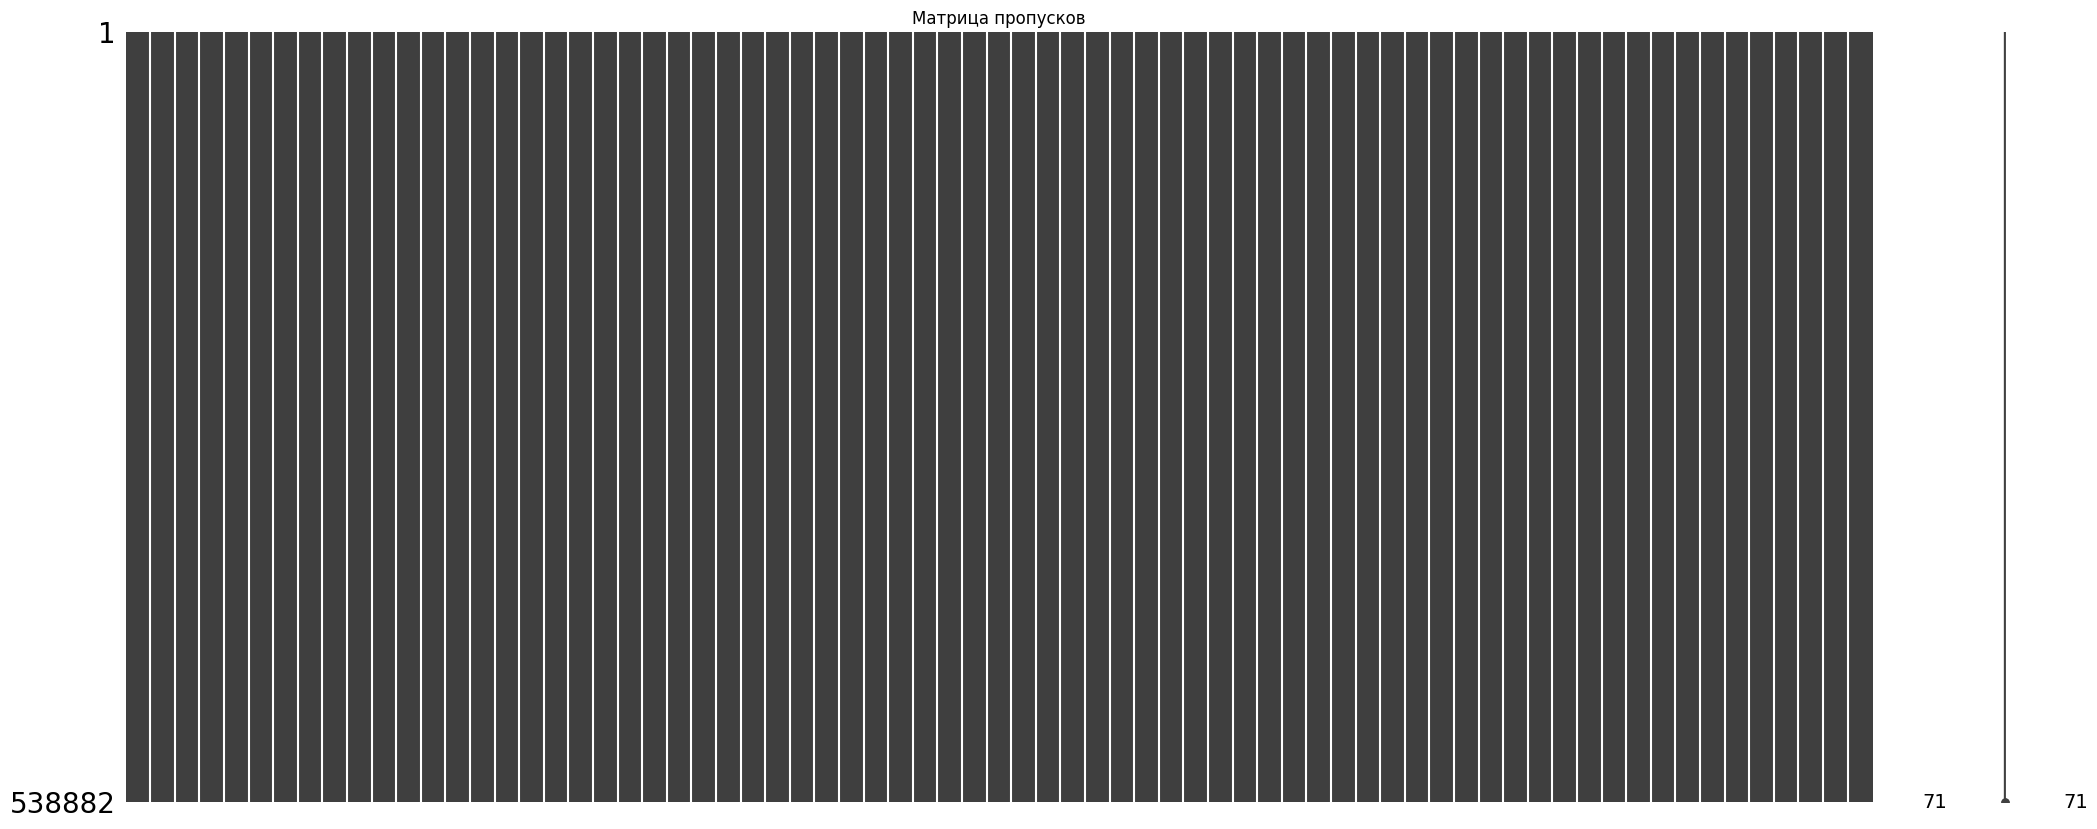

In [11]:
msno.matrix(df)
plt.title('Матрица пропусков');

- В датасете отсуствуют пропуски

### Проверка на дубликаты

In [12]:
df.duplicated().sum()

64129

- В данных есть дубликаты, однако их удаление не привело к улучшению метрики модели, поэтому оставим их.

### Анализ баланса классов

Посмотрим количество уникальных классов в целевом признаке `Label`

In [13]:
df['label'].unique()

array(['BENIGN', 'PortScan', 'DoS Hulk', 'DDoS', 'Bot', 'Infiltration',
       'Web Attack � Brute Force', 'Web Attack � XSS',
       'Web Attack � Sql Injection', 'FTP-Patator', 'SSH-Patator',
       'DoS slowloris', 'DoS Slowhttptest', 'DoS GoldenEye', 'Heartbleed'],
      dtype=object)

In [14]:
df['label'].nunique()

15

- Мы имеем 15 уникальных классов целевого признака
- Имена целевой переменной имеют странные символы. Приведём к общему виду

In [15]:
df['label'] = df['label'].str.lower().str.replace('[� -]', '_', regex=True)

In [16]:
df['label'].unique()

array(['benign', 'portscan', 'dos_hulk', 'ddos', 'bot', 'infiltration',
       'web_attack___brute_force', 'web_attack___xss',
       'web_attack___sql_injection', 'ftp_patator', 'ssh_patator',
       'dos_slowloris', 'dos_slowhttptest', 'dos_goldeneye', 'heartbleed'],
      dtype=object)

Построим столбчатый график, что бы посмотреть распределение классов

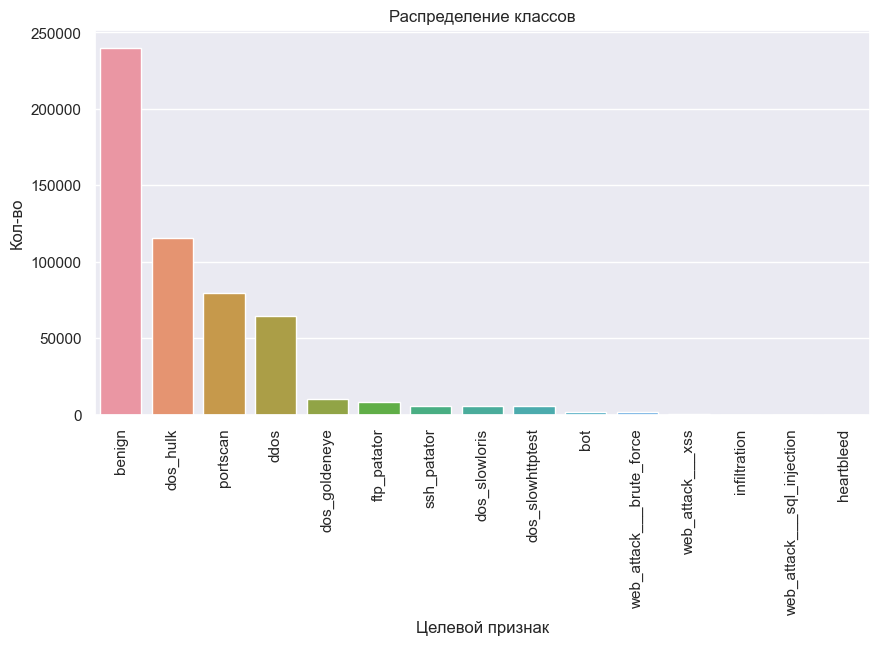

In [17]:
sns.set(style='darkgrid')
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='label', order=df['label'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Распределение классов')
plt.xlabel('Целевой признак')
plt.ylabel('Кол-во');

In [18]:
value_counts = df['label'].value_counts()
perc = ((value_counts / len(df)) * 100).round(4)
result_df = pd.DataFrame({'Кол-во': value_counts.values, 'Процент': perc})

result_df.head(15).style.set_caption('Таблица частоты целевого признака')

,Кол-во,Процент
benign,239800,44.499500
dos_hulk,115527,21.438300
portscan,79587,14.768900
ddos,64365,11.944200
dos_goldeneye,10293,1.910100
ftp_patator,7935,1.472500
ssh_patator,5897,1.094300
dos_slowloris,5796,1.075600
dos_slowhttptest,5499,1.020400
bot,1956,0.363000


- Присутствует сильный дисбаланс классов. На этапе подготовке данных для обучения, попробуем сбалансировать.

## Моделирование

После предобработки данных перейдём к обучению моделей. Сперва разделим выборки на обучающую и тестовую, затем исправим дисбаланс классов, а потом обучим 2 модели на тренировочных данных: логистическую регрессию и градиентный бустинг. 

Решаем задачу мультиклассовой классификации и в классах имеется дисбаланс классов. Нам важно, что бы даже самый малый класс, определялся с высокой точностью.

Будем использовать метрику F1-мера в варианте macro. Используем вариант macro, потому что у нас задача мультиклассовой классификации. Macro вариант помогает при дисбалансе классов. Он считает f1-меру для каждой класса, а затем считает среднее значение. Из-за этого даже самый малый класс имеет одинаковый вес при расчёте средней метрики.

### Разделим на обучающую и тестовую выбрку

Выделим признаки и целевой признак

In [19]:
features, target = df.drop(['label'], axis=1), df['label']

Разделим на обучающую и тестовую выборку

In [20]:
train_features, test_features, train_target, test_target = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.25, 
                                                                            random_state=STATE)

In [21]:
print('Размер обучающей выборки:', train_features.shape)
print('Размер тестовой выборки:', test_features.shape)

Размер обучающей выборки: (404161, 70)
Размер тестовой выборки: (134721, 70)


### Борьба с дисбалансом классов

Будем использовать метод баланса классов SMOTE. Он увеличит количество записей меньшего класса до требуемого уровня. Эмпирически были подобраны размеры меньших классов.

In [22]:
# Словарь с размерами меньших классов
sampling_strategy_smote = {'heartbleed': 500, 'web_attack___sql_injection': 500, 'infiltration': 500, 
                           'web_attack___xss': 2000, 'bot': 5000, 'web_attack___brute_force': 5000}

# Создаем экземпляр SMOTE с заданными параметрами
sm = SMOTE(sampling_strategy=sampling_strategy_smote, random_state=STATE)

# Применяем метод SMOTE для балансировки классов
train_features, train_target = sm.fit_resample(train_features, train_target)

In [23]:
value_counts = train_target.value_counts()
perc = ((value_counts / len(train_features)) * 100).round(4)
result_df = pd.DataFrame({'Кол-во': value_counts.values, 'Процент': perc})

result_df.head(15).style.set_caption('Таблица частоты целевого признака')

,Кол-во,Процент
benign,179886,43.394300
dos_hulk,86600,20.890700
portscan,59632,14.385200
ddos,48465,11.691300
dos_goldeneye,7686,1.854100
ftp_patator,5922,1.428600
bot,5000,1.206200
web_attack___brute_force,5000,1.206200
ssh_patator,4426,1.067700
dos_slowloris,4286,1.033900


### Модель логистическая регрессия

In [24]:
# Создаем пайплайн для логистической регрессии с предварительным масштабированием данных
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=STATE))
])

# Определяем сетку гиперпараметров для логистической регрессии
param_lr = {
    'classifier__C': [0.01, 1, 10],
    'classifier__penalty': ['l1', 'l2']
}

# Инициализируем GridSearchCV с пайплайном и сеткой гиперпараметров
LR = GridSearchCV(pipeline_lr, param_lr, cv=5, scoring='f1_macro')

# Обучаем модель с кросс-валидацией
LR.fit(train_features, train_target)

# Выводим лучшие найденные параметры и оценку F1-меры
print("Лучшие параметры:", LR.best_params_)
print("F1-мера:", LR.best_score_)

Лучшие параметры: {'classifier__C': 10, 'classifier__penalty': 'l2'}
F1-мера: 0.7433808705957927


### Модель градиентного бустинга в реализации Lightgbm

Построим конвеер, в котором перед обучением данные пройдут стандартизацию. Подбирать гиперпараметры будем через поиск по сетке.

In [25]:
# Создаем пайплайн для LightGBM с предварительным масштабированием данных
pipeline_lgbm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', lgb.LGBMClassifier(random_state=STATE))
])

# Определяем сетку гиперпараметров для LightGBM
param_lgbm = {
    'classifier__learning_rate': [0.01],
    'classifier__max_depth': [12],
    'classifier__n_estimators': [150]
}
'''
param_lgbm = {
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__max_depth': [8, 10, 12],
    'classifier__n_estimators': [50, 100, 150]
}
'''
# Инициализируем GridSearchCV с пайплайном и сеткой гиперпараметров
LGBM = GridSearchCV(pipeline_lgbm, param_lgbm, cv=5, scoring='f1_macro')

# Обучаем модель с кросс-валидацией
LGBM.fit(train_features, train_target)

# Выводим лучшие найденные параметры и оценку F1-мер
print("Лучшие параметры:", LGBM.best_params_)
print("F1-мера:", LGBM.best_score_)

Лучшие параметры: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 12, 'classifier__n_estimators': 150}
F1-мера: 0.9483473756934409


Обучив 2 модели, лучший результат показла модель LightGBM.

## Тестирование лучшей модели

Протестируем модель градиентного бустинга в реализации LightGBM, проверим её на тестовой выборке и оценим важность признаков.

### Протестируем модель градиентного бустинга LightGBM

In [26]:
# best_model содержит лучшую найденную модель
best_model = LGBM

# Делаем предсказания на тестовых признаках
pred = best_model.best_estimator_.predict(test_features)

# Вычисляем отчет о классификации
class_report = classification_report(test_target, pred)

# Выводим отчет о классификации
print(class_report)

                            precision    recall  f1-score   support

                    benign       1.00      1.00      1.00     59914
                       bot       0.96      0.98      0.97       475
                      ddos       1.00      1.00      1.00     15900
             dos_goldeneye       1.00      1.00      1.00      2607
                  dos_hulk       1.00      1.00      1.00     28927
          dos_slowhttptest       0.99      0.99      0.99      1364
             dos_slowloris       1.00      0.99      1.00      1510
               ftp_patator       1.00      1.00      1.00      2013
                heartbleed       1.00      1.00      1.00         3
              infiltration       1.00      0.80      0.89        10
                  portscan       1.00      1.00      1.00     19955
               ssh_patator       1.00      1.00      1.00      1471
  web_attack___brute_force       0.73      0.90      0.80       396
web_attack___sql_injection       1.00      0.50

- Получили метрику f1-мера равную 0.91

### Посмотрим важность признаков

Проанализируем, как каждый признак влияет на классификацию классов. С помощью библиотеки shap построим столбчатый график.

In [27]:
X_encoded = best_model.best_estimator_['scaler'].fit_transform(train_features)
best_model = best_model.best_estimator_['classifier'].fit(X_encoded, train_target)

# Вычисляем важность признаков с использованием SHAP
shap_values = shap.TreeExplainer(best_model).shap_values(X_encoded)

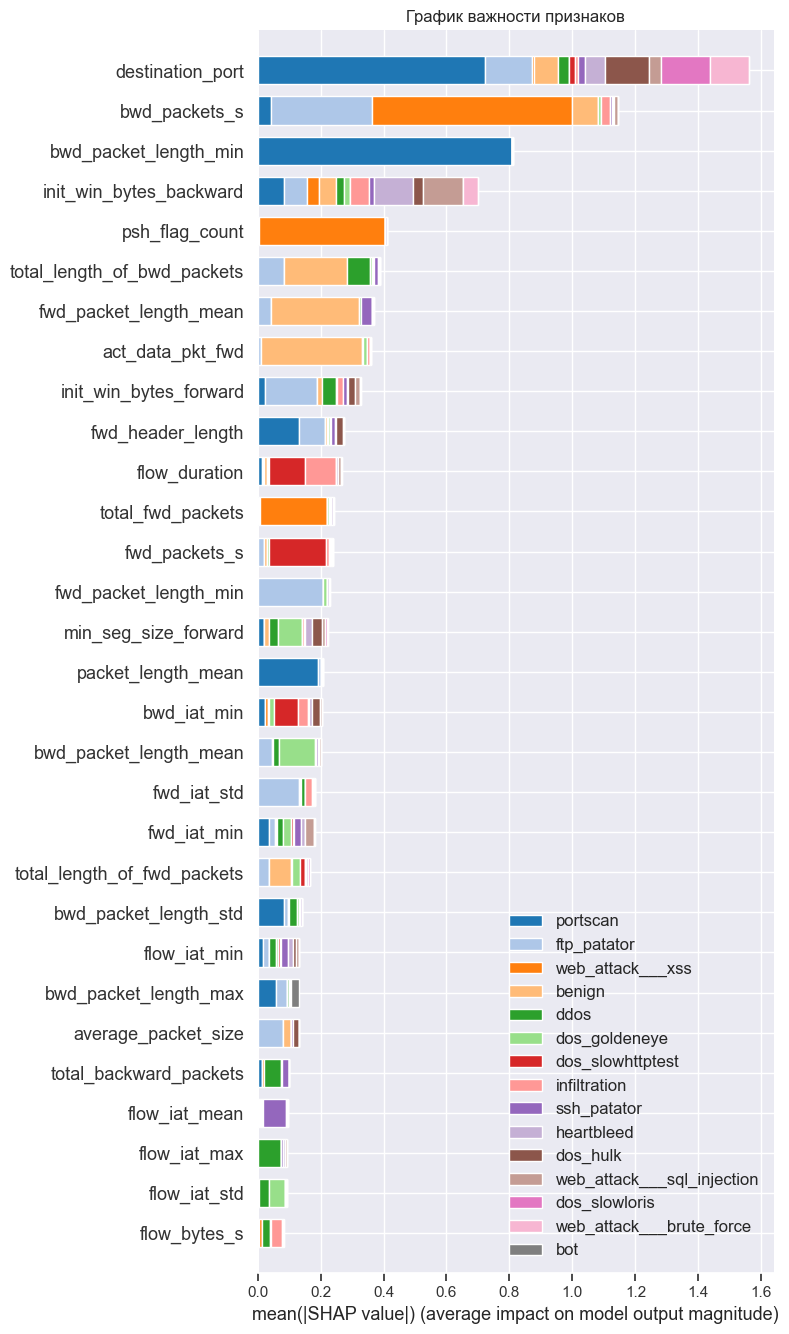

In [28]:
plt.title('График важности признаков')
shap.summary_plot(shap_values, 
                  X_encoded, 
                  plot_type='bar', 
                  feature_names=train_features.columns, 
                  max_display=30,
                  class_names=train_target.unique(),
                  color=plt.get_cmap("tab20"))

По графику можно сделать такие выводы:

- Разные признаки влияют на классификацию разных классов
- Есть часть признаков, которые не оказывают влияния на модель
- В нашем датасете после удаления нулевых столбцов осталось 70 столбцов. Можно выделить 5 наиболее важных признаков, оказывающих наибольшее влияние:
    - `destination_port`
    - `bwd_packets_s`
    - `bwd_packet_length_min`
    - `init_win_bytes_backward`
    - `psh_flag_count`
- Хотя эти признаки и вносят больший вклад, остальные не менее важны. Если присмотреться, то некоторый незначительный признак значительно влияет на обнаружение конкретного класса угрозы. Удаление каких-либо признаков, кроме признаков с нулями, не привело к улучшению метрики

## Сохраним модель для создания REST API сервиса с использованием Flask и Docker

Для разработки REST API сервиса, потребуется выгрузить модель в отдельный файл. 

```python
# Код сохраняющий модель
model = LGBM.best_estimator_
model['classifier'].booster_.save_model('lightgbm_best_model.txt')
```

Создал REST API сервис, который позволяет выполнять предсказания с использованием лучшей модели. В этом сервисе я использовал Python, библиотеку Flask и Docker. Процесс создания сервиса включал следующие шаги:

1) Модель машинного обучения

2) main.py: В файле main.py я загрузил обученную модель и создал функцию, которая принимает входные данные и возвращает предсказания, используя Flask.

3) Docker: Для упрощения развертывания и управления приложением я создал Docker-образ. Docker обеспечивает изолированную среду для приложения, что упрощает его переносимость и масштабируемость.

4) Тестирование: Для проверки работы сервиса я создал файл measure_response, который отправляет тестовый запрос к API и оценивает его производительность и правильность ответов.

## Выводы

В этом проекте нам нужно было построить модель для классификации трафика на нормальный и злонамеренный с целью автоматизации выявления трафика. Получили хорошую метрику и разработали REST API сервис с помощью Flask и контейнеров docker.

**Результаты моделей**

Обучили две модели и получили такие результаты метрики F1-мера на тренировочных данных: Логистическая регрессии - 0.74, Градиентный бустинг - 0.94

На основании этих результатов выбрали и протестировали лучшую модель градиентный бустинг в реализации LightGBM. Получили такие результаты:

- Суммарная метрика F1-мера - 0.91

- Метрика на тренировочных данных больше, чем на тестовой, есть небольшое переобучение. Однако так получилось добиться максимальной метрики на тестовых данных.

- Сетка гиперпараметров:

    - learning_rate: [0.01, 0.1, 0.3]
    
    - max_depth: [8, 10, 12]
    
    - n_estimators': [50, 100, 150]
    
- Лучшие гиперпараметры: learning_rate=0.01, max_depth=12, n_estimators=150

**Выбор признаков**

При обучении модели использовали не все признаки. Удалили 8 признаков, потому что в них находились все нулевые значения. Это не улучшило метрику, однако увеличило скорость обучения.

**Предобработка признаков**

В данных был дисбаланс классов. С помощью SMOTE увеличили меньшие классы до достаточного уровня. Числовые признаки были стандартизированы.

**REST API**

Cоздал REST API сервис, который позволяет выполнять предсказания с использованием лучшей модели. В этом сервисе использовали Python, библиотеку Flask и Docker.

**Трудности**

В процессе работы столкнулся с трудностями:

- Не получилось достичь высоких значений по 2-ум классам: web_attack___xss и web_attack___sql_injection. В этих классах слишком мало записей. Балансировка улучшила результат, однако недостаточно хорошо. Возможно на этих данных и невозможно достичь высоких значений метрики.

**Итого**

В итоге, проект позволяет автоматизировать процесс выявления злонамеренного трафика, что является важным шагом для обеспечения безопасности сети и обеспечения качественного функционирования веб-сервисов.

In [35]:
df.iloc[50].to_dict()

{'destination_port': 11273,
 'flow_duration': 36993,
 'total_fwd_packets': 2,
 'total_backward_packets': 1,
 'total_length_of_fwd_packets': 0,
 'total_length_of_bwd_packets': 0,
 'fwd_packet_length_max': 0,
 'fwd_packet_length_min': 0,
 'fwd_packet_length_mean': 0.0,
 'fwd_packet_length_std': 0.0,
 'bwd_packet_length_max': 0,
 'bwd_packet_length_min': 0,
 'bwd_packet_length_mean': 0.0,
 'bwd_packet_length_std': 0.0,
 'flow_bytes_s': 0.0,
 'flow_packets_s': 81.09642365,
 'flow_iat_mean': 18496.5,
 'flow_iat_std': 25954.354,
 'flow_iat_max': 36849,
 'flow_iat_min': 144,
 'fwd_iat_total': 36993,
 'fwd_iat_mean': 36993.0,
 'fwd_iat_std': 0.0,
 'fwd_iat_max': 36993,
 'fwd_iat_min': 36993,
 'bwd_iat_total': 0,
 'bwd_iat_mean': 0.0,
 'bwd_iat_std': 0.0,
 'bwd_iat_max': 0,
 'bwd_iat_min': 0,
 'fwd_psh_flags': 0,
 'fwd_urg_flags': 0,
 'fwd_header_length': 40,
 'bwd_header_length': 20,
 'fwd_packets_s': 54.06428,
 'bwd_packets_s': 27.03214,
 'min_packet_length': 0,
 'max_packet_length': 0,
 'pac